## Import libraries 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [3]:
%pwd

'/Users/rouenlee/github/RNN'

## Import dataset

In [4]:
# import the training set 
train = pd.read_csv("/Users/rouenlee/github/RNN/Google_Stock_Price_Train.csv")
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
# get the index
train_set = train.iloc[:,1:2].values #.values create numpy array 

In [6]:
type(train_set)

numpy.ndarray

In [7]:
train_set.shape

(1258, 1)

In [8]:
train_set[:5]

array([[ 325.25],
       [ 331.27],
       [ 329.83],
       [ 328.34],
       [ 322.04]])

## Scaling

In [9]:
# Scaling 
# x_norm = (x - min(x))/( max(x) - min(x) )
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range = (0,1))
train_set_scaled = sc.fit_transform(train_set) 
# fit: find min and max, transform: perform scaling

In [10]:
train_set_scaled[:5]

array([[ 0.08581368],
       [ 0.09701243],
       [ 0.09433366],
       [ 0.09156187],
       [ 0.07984225]])

In [45]:
train_set_scaled.shape

(1258, 1)

## Building the RNN

In [46]:
# Building the RNN - takes 60 previous time steps and predict the value... 
# of the 60 time step
X_train = []
y_train = []

for i in range(60,train_set_scaled.shape[0]):
    X_train.append(train_set_scaled[i-60:i,:])
    y_train.append(train_set_scaled[i,:])
    
# make lists numpy array 
X_train, y_train = np.array(X_train), np.array(y_train)

Note that X_train and y_train are both transformed according to the same scale!

In [47]:
print("shape of X_train is ",X_train.shape)
print("shape of y_train is ",y_train.shape)

shape of X_train is  (1198, 60, 1)
shape of y_train is  (1198, 1)


In [48]:
# reshape to dimensions required by keras library
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [49]:
# Build the RNN
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
from keras.layers import Dropout

In [50]:
 # predicting a continuous output, we are doing a regression
regressor = Sequential()

Note: all codes in the cell below must be run only once 

In [51]:
# add first LSTM layer and Dropout regularisation 
# units: LSTM cells in a layer 
# return sequences, because we have several LSTM layers
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2)) 

# adding second LSTM layer 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 

# adding third LSTM layer 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 

# adding fourth LSTM layer 
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2)) 

# Adding the output layer
regressor.add(Dense(units = 1))

# RMSprop or Adam in RNNs
# loss: regression prob, so MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [52]:
# Fitting the RNN to the training set 
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

INFO (theano.gof.compilelock): Refreshing lock /Users/rouenlee/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0449
Epoch 2/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0061
Epoch 3/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0052
Epoch 4/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0060
Epoch 5/100
1198/1198 [==============================] - 7s 5ms/step - loss: 0.0050
Epoch 6/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0051
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0049
Epoch 8/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0040
Epoch 9/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0048
Epoch 10/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0043
Epoch 11/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0041A:
Epoch 12/100
1198/1198 [==============================] - 7s 6ms/step - 

19 Jul 2018: Took me approx 10 mins to run the above

## Making predictions and visualising the results 

Recall:

- training set has data from 2012-2016
- test set has data in 2017.
- to predict price in 2017, we need to have X data from 2016 and before (since we are predicting 2017 price by 60 preceding time steps).

In [133]:
# Get the real stock price of 2017
test = pd.read_csv("/Users/rouenlee/github/RNN/Google_Stock_Price_Test.csv")
real_stock_price = test.iloc[:,1:2].values 

In [134]:
# get the predicted stock price of 2017
dataset_total = pd.concat((train["Open"],test["Open"]),axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)-60:].values 
inputs = inputs.reshape(-1,1)

In [135]:
# use scaling applied to the training set! use transform 
inputs = sc.transform(inputs)

In [136]:
X_test = []

for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
# make lists numpy array 
X_test = np.array(X_test)

# 3-d structure (training exmaples, timesteps, no. features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

Alternative method to get X_test: (to me, this way is more intuitive)

In [137]:
# dataset total is test and train data concatenated
dataset_total = dataset_total.values.reshape(-1,1)
scaled_dataset_total = sc.transform(dataset_total)

In [138]:
test_size = real_stock_price.shape[0]
total_size = scaled_dataset_total.shape[0]
print("test size is " ,test_size)
print("total size is " ,total_size)

test size is  20
total size is  1278


In [139]:
my_X_test = []
for i in range(total_size - test_size ,total_size):
    my_X_test.append(scaled_dataset_total[i-60:i,:])
my_X_test = np.array(my_X_test)
my_X_test = np.reshape(my_X_test, (my_X_test.shape[0], my_X_test.shape[1],1))

In [140]:
# Sanity check 
my_X_test.shape

(20, 60, 1)

In [143]:
# if all correct, returns 20*60 = 1200
sum(sum(my_X_test == X_test))

array([1200])

## Visualising results 

In [58]:
# Visualizing results 
predicted_stock_price = regressor.predict(X_test)

# inverse scaling of predictions 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

INFO (theano.gof.compilelock): Refreshing lock /Users/rouenlee/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


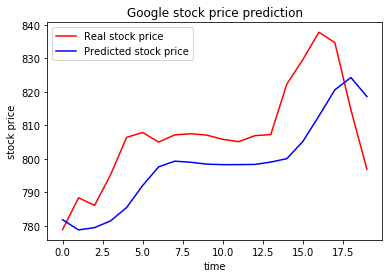

In [59]:
# Visualising the results 
plt.plot(real_stock_price, color = 'red', label = 'Real stock price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted stock price')
plt.title('Google stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()